-----------

# Transfer Learning

-----------
-----------

In this lab, you will see how you can use a pre-trained model to achieve good results even with a small training dataset. This is called _transfer learning_ and you do this by leveraging the trained layers of an existing model and adding your own layers to fit your application. For example, you can:

1. just get the convolution layers of one model
2. attach some dense layers onto it
3. train just the dense network
4. evaluate the results

Doing this will allow you to save time building your application because you will essentially skip weeks of training time of very deep networks. You will just use the features it has learned and tweak it for your dataset. Let's see how these are done in the next sections.

-----------

### <font color='brown'> Setup the pre-trained model </font>

You will need to prepare pretrained model and configure the layers that you need. For this exercise, you will use the convolution layers of the [InceptionV3](https://arxiv.org/abs/1512.00567) architecture as your base model. To do that, you need to:

1. Set the input shape to fit your application. In this case. set it to `150x150x3` as you've been doing in the last few labs.

2. Pick and freeze the convolution layers to take advantage of the features it has learned already.

3. Add dense layers which you will train.

Let's see how to do these in the next cells.

First, in preparing the input to the model, we would want to fetch the pretrained weights of the InceptionV3 model and remove the fully connected layer at the end because you will be replacing it later. 

We will also specify the input shape that your model will accept. 

Lastly, we will want to freeze the weights of these layers because they have been trained already.

------------------------------

In [10]:
#!pip install wget
# import wget
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
## Function for Plotting Loss and Accuracy
# ----------------------------------------

def plot_loss_acc(history):
    
    import matplotlib.pyplot as plt
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))
    plt.figure(figsize=(13,3))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy', color='red')
    plt.title('Training and validation accuracy')

    
    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss', color='red')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()
    
    

In [11]:
# Set the weights file you downloaded into a variable
local_weights_file = 'C:/Inception - Transfer Learning/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
    layer.trainable = False

You can see the summary of the model below. You can see that it is a very deep network. You can then select up to which point of the network you want to use. As Laurence showed in the exercise, you will use up to mixed_7 as your base model and add to that. This is because the original last layer might be too specialized in what it has learned so it might not translate well into your application. mixed_7 on the other hand will be more generalized and you can start with that for your application. After the exercise, feel free to modify and use other layers to see what the results you get.

In [13]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 7, 7, 192)   576         ['conv2d_74[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_70 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_70[0][0]'] 
                                                                                                  
 activation_74 (Activation)     (None, 7, 7, 192)    0           ['batch_normalization_74[0][0]'] 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 3, 3, 320)    552960      ['activation_70[0][0]']          
          

                                                                                                  
 activation_82 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 3, 3, 384)    0           ['batch_normalization_83[0][0]'] 
                                                                                                  
 batch_normalization_84 (BatchN  (None, 3, 3, 192)   576         ['conv2d_84[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_76 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 mixed9_0 

 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 3, 3, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 (Concatenate)         (None, 3, 3, 768)    0           ['activation_87[0][0]',          
                                                                  'activation_88[0][0]']          
                                                                                                  
 concatenate_1 (Concatenate)    (None, 3, 3, 768)    0           ['activation_91[0][0]',          
                                                                  'activation_92[0][0]']          
                                                                                                  
 activatio

In [14]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')

print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


-------------------
### <font color='brown'> Add dense layers for your classifier </font>

Next, you will add dense layers to your model. 

These will be the layers that you will train and is tasked with recognizing cats and dogs. 

You will add a [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer as well to regularize the output and avoid overfitting.

-------------------

In [16]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)               

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

 batch_normalization_10 (BatchN  (None, 16, 16, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 16, 16, 32)  96          ['conv2d_11[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_5 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_5[0][0]']  
                                                                                                  
 activation_7 (Activation)      (None, 16, 16, 64)   0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activatio

 conv2d_20 (Conv2D)             (None, 16, 16, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 16, 16, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 16, 16, 48)  144         ['conv2d_20[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_23 (BatchN  (None, 16, 16, 96)  288         ['conv2d_23[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

                                                                                                  
 conv2d_34 (Conv2D)             (None, 7, 7, 128)    98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 7, 7, 128)   384         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_34 (Activation)     (None, 7, 7, 128)    0           ['batch_normalization_34[0][0]'] 
                                                                                                  
 conv2d_35 (Conv2D)             (None, 7, 7, 128)    114688      ['activation_34[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 activation_44 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_44[0][0]']          
                                                                                                  
 batch_normalization_45 (BatchN  (None, 7, 7, 160)   480         ['conv2d_45[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_45[0][0]'] 
                                                                                                  
 conv2d_41

 batch_normalization_55 (BatchN  (None, 7, 7, 160)   480         ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 7, 7, 160)    0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_51 (Conv2D)             (None, 7, 7, 160)    122880      ['mixed5[0][0]']                 
                                                                                                  
 conv2d_56 (Conv2D)             (None, 7, 7, 160)    179200      ['activation_55[0][0]']          
                                                                                                  
 batch_normalization_51 (BatchN  (None, 7, 7, 160)   480         ['conv2d_51[0][0]']              
 ormalizat

 conv2d_61 (Conv2D)             (None, 7, 7, 192)    147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 7, 7, 192)    258048      ['activation_65[0][0]']          
                                                                                                  
 batch_normalization_61 (BatchN  (None, 7, 7, 192)   576         ['conv2d_61[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_66 (BatchN  (None, 7, 7, 192)   576         ['conv2d_66[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

In [17]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [19]:
# Define our example directories and files
base_dir = 'cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
# Train the model.

# We can now train the model. 
# We will do 20 epochs and plot the results afterwards.

history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 27s - loss: 0.4018 - accuracy: 0.8605 - val_loss: 0.1798 - val_accuracy: 0.9230 - 27s/epoch - 266ms/step
Epoch 2/20
100/100 - 15s - loss: 0.2193 - accuracy: 0.9095 - val_loss: 0.1153 - val_accuracy: 0.9560 - 15s/epoch - 147ms/step
Epoch 3/20
100/100 - 15s - loss: 0.2049 - accuracy: 0.9205 - val_loss: 0.2786 - val_accuracy: 0.9210 - 15s/epoch - 147ms/step
Epoch 4/20
100/100 - 14s - loss: 0.1966 - accuracy: 0.9315 - val_loss: 0.1133 - val_accuracy: 0.9600 - 14s/epoch - 145ms/step
Epoch 5/20
100/100 - 15s - loss: 0.1966 - accuracy: 0.9275 - val_loss: 0.1336 - val_accuracy: 0.9610 - 15s/epoch - 146ms/step
Epoch 6/20
100/100 - 14s - loss: 0.1971 - accuracy: 0.9330 - val_loss: 0.1372 - val_accuracy: 0.9550 - 14s/epoch - 145ms/step
Epoch 7/20
100/100 - 14s - loss: 0.1741 - accuracy: 0.9405 - val_loss: 0.1222 - val_accuracy: 0.9590 - 14s/epoch - 145ms/step
Epoch 8/20
100/100 - 14s - loss: 0.1680 - accuracy: 0.9405 - val_loss: 0.1307 - val_accuracy: 0.9650 - 14s/epoch - 141

C:\Users\Cloudy\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:18: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
C:\Users\Cloudy\anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


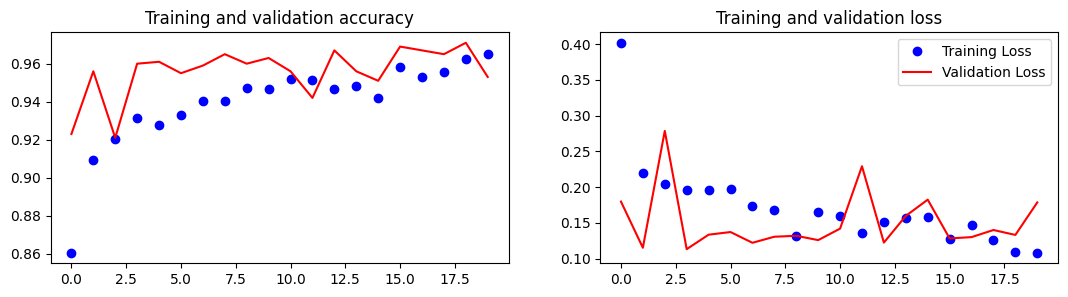

In [24]:
# Plotting
# --------
plot_loss_acc(history)

1) We saw Transfer Learning, and how we can take an existing model, freeze many of its layers to prevent them being retrained, and effectively 'remember' the convolutions it was trained on to fit images. 

2) We then added your own DNN underneath this so that we could retrain on our images using the convolutions from the other model. 

3) You learned about regularization using dropout to make your network more efficient in preventing over-specialization and thus overfitting.